# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

___
##### The goal is to develop a predictive model to analyze and determine the most significant factors influencing used car prices. 
This involves collecting and preparing relevant datasets, conducting exploratory data analysis to identify potential features, and employing statistical and machine learning techniques to quantify the impact of these features on pricing. Key metrics for model performance will be evaluated to ensure accuracy and reliability in predicting used car prices

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Exploratory Data Analysis

1. Read CSV
2. Understand data structure and independent variables
3. Determine missing values and explore the right strategy for treating them (drop columns or rows, and filling missing values - mode, mean or use KNN)
4. Understand categorical variables
 

In [793]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import root_mean_squared_error

import time


In [794]:
# read vehicles data

vehicles = pd.read_csv('data/vehicles.csv')

print("Number of rows and columns in the dataset:", vehicles.shape)


Number of rows and columns in the dataset: (426880, 18)


In [795]:
# review the columns in the data set 

vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [796]:
# check the summary statistics of the numerical values

vehicles[['price', 'year', 'odometer']].describe()  

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


--- 
* The `price, odometer and year` columns have a wide range of data. There is price max of 3B, and odometer readings of 1M. While an odometer reading that high may be possible, for the purposes of this analysis we will ignore odometer readings about 500k

In [797]:
# unique values per column

vehicles.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [798]:

# Count missing %s
vehicles.isna().mean().round(4)*100


id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [799]:
#Descriptive statistics for categorical variables
vehicles.describe(include=['object', 'category'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


--- 
* Categorical variables: The columns `region`, `manufacturer`, `model`, and `state` have a large number of unique values, requiring an appropriate strategy for treatment.
* VIN numbers: There are only 265K unique VIN numbers in a dataset of 426K observations, indicating possible duplicate entries.
* Missing values: The columns `condition`, `cylinders`, `VIN`, `drive`, `size`, `type`, and `paint_color` have more than 25% missing values.
* Outliers: The columns `price`, `odometer`, and `year` have a wide range of data, which may require outlier treatment.


## Data Quality / Clean up

After an initial review of data, the following data quality and clean up steps need to be addressed:

1. Remove irrelevant data: IDs, VINs
2. Remove categorical columns with a large number of unique values (region, model, state) - These can be added back after the first pass of model creation if needed
3. Remove columns with more than 50% missing data (size)
4. Drop duplicate rows
5. Convert data types:
    - Extract the number of cylinders as a numerical value
6. Perform outlier analysis and removal for the price, odometer, and year columns



In [800]:

# remove object columns that we intuitively know to be not related to the price of a used car such as id, VIN
vehicles_clean = vehicles.drop(columns = ['id', 'VIN'])

# remove categorical variables with very large unique values - region(404), model(29649), state(51). This may be reintroduced later 
# if do not find any other variables that can help build a good model
vehicles_clean = vehicles_clean.drop(columns = ['region', 'model', 'state'])

# remove columns with > 50% missing values
vehicles_clean = vehicles_clean.drop(columns = ['size'])

# drop duplicates
vehicles_clean = vehicles_clean.drop_duplicates()

vehicles_clean.shape

(244870, 12)

In [801]:

# convert cylinders to numeric values
vehicles_clean['cylinders'] = vehicles_clean['cylinders'].str.replace('cylinders', '', regex=False)
vehicles_clean['cylinders_numeric'] = pd.to_numeric(vehicles_clean['cylinders'], errors='coerce', downcast='integer')
print(vehicles_clean['cylinders_numeric'].value_counts())

vehicles_clean.drop(columns = 'cylinders', inplace=True)


cylinders_numeric
4.0     56018
6.0     55892
8.0     41499
5.0      1355
10.0      717
3.0       449
12.0      153
Name: count, dtype: int64


In [802]:

# Address outliers in price, odometer and year columns by keeping values as a function of < 90th percentile
#

def address_outlier_iqr(df, column):
    iqr = df[column].quantile(.95) - df[column].quantile(.05)
    #lower_bound = df[column].quantile(.05) - 1.5 * iqr
    lower_bound = 0
    upper_bound = df[column].quantile(.95) + 1.5 * iqr
    print(lower_bound, upper_bound)

    df_without_outliers = df[(df[column] > lower_bound) & (df[column] < upper_bound)].copy()
    
    iqr_data_lost = 1-(df_without_outliers.shape[0]/df.shape[0])
    print("We lost {:.2%} of the data by the IQR method".format(iqr_data_lost), "for the", column, "column")
    
    return df_without_outliers

# vehicles_clean = address_outlier_iqr(vehicles_clean, 'price')
# vehicles_clean = address_outlier_iqr(vehicles_clean, 'odometer')
# vehicles_clean = address_outlier_iqr(vehicles_clean, 'year')

vehicles_clean = vehicles_clean[(vehicles_clean['price'] > 1) & (vehicles_clean['price'] < 100000)]
vehicles_clean = vehicles_clean[(vehicles_clean['odometer'] > 1) & (vehicles_clean['odometer'] < 500000)]
vehicles_clean = vehicles_clean[(vehicles_clean['year'] > 1925)]

vehicles_clean.select_dtypes(include=['float64', 'int64']).describe()


,price,year,odometer,cylinders_numeric
count,221743.000000,221743.000000,221743.000000,145727.000000
mean,15242.084242,2009.227101,106302.715829,5.809075
std,13213.883375,10.478521,64293.010759,1.609941
min,2.000000,1926.000000,2.000000,3.000000
25%,5987.000000,2006.000000,56616.500000,4.000000
50%,11000.000000,2012.000000,101977.000000,6.000000
75%,20590.000000,2016.000000,148000.000000,8.000000
max,99999.000000,2022.000000,499232.000000,12.000000


In [803]:
vehicles_clean.shape

(221743, 12)

In [804]:
# check the percentages of missing values after initial clean up

vehicles_clean.isna().mean().round(4)*100

price                 0.00
year                  0.00
manufacturer          3.85
condition            37.52
fuel                  0.55
odometer              0.00
title_status          1.59
transmission          0.37
drive                27.64
type                 25.03
paint_color          28.70
cylinders_numeric    34.28
dtype: float64

## Exploratory Data Analysis (EDA)

* Univariate

* Bi-variate (price as the main focus)
    For ex: how cylinders and prices move together


In [805]:
# Helper function to create seaborn plots that share the same appearance attributes
#   such as: heading, title, x-y labels, and placement of the legend
# 
def render_plot(ax, heading='', subtitle='', xlabel='', ylabel='', rotation=20, plotname='',displaybarlabel=True):
    
    plt.suptitle(heading, fontsize = 18)                        # main heading of the plot
    plt.title(subtitle, fontsize = 12)                          # sub title of the plot
    
    ax.set(xlabel=xlabel, ylabel=ylabel)                        # x and y labels
    
    if displaybarlabel == True:
        for i in ax.containers:
            ax.bar_label(i,)                                    # display values on bars
        
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
        
    for patch in ax.patches:                                    # remove bars that do not have any values
        if patch.get_height() == 0: 
            patch.set_visible(False)
    
    if ax.get_legend():                                         # if legend is present, set the location to upper right
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))     
        
    ax.tick_params(rotation=rotation, axis='x')                 # rotate the labels
    
    if len(plotname) > 0:
        filename = 'plots/' + plotname
        ax.get_figure().savefig(filename, bbox_inches='tight')
    

# Set palette and grid style
# 
sns.set_palette('pastel')
sns.set_style("whitegrid")

#### EDA for Numerical Variables

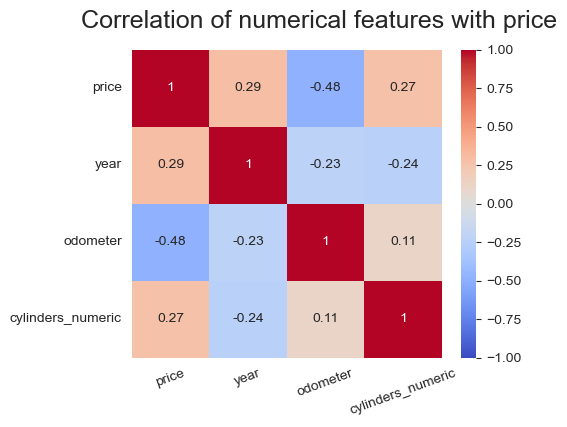

In [ ]:

# Create a correlation heatmap using numerical features

plt.figure(figsize=(5, 4))
ax = sns.heatmap(vehicles_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)


render_plot(ax, heading = 'Correlation of numerical features with price', subtitle = '', 
            xlabel = '', 
            ylabel = '',
            plotname = '1-numerical_corr.png')


# plt.title('Correlation')
# plt.show()
# plt.savefig('images/corr.png', bbox_inches='tight')

### Correlation Plot Analysis

- **Price and Odometer**: There is a moderate negative correlation between price and odometer reading (-0.41). This indicates that as the odometer reading increases, the price of the car tends to decrease. This is expected as cars with higher mileage are generally less expensive.

- **Price and Cylinders**: There is a positive correlation between price and the number of cylinders (0.25). This suggests that cars with more cylinders tend to be priced higher. This could be due to the fact that cars with more cylinders are used for special purposes, and perhaps even be considered premium

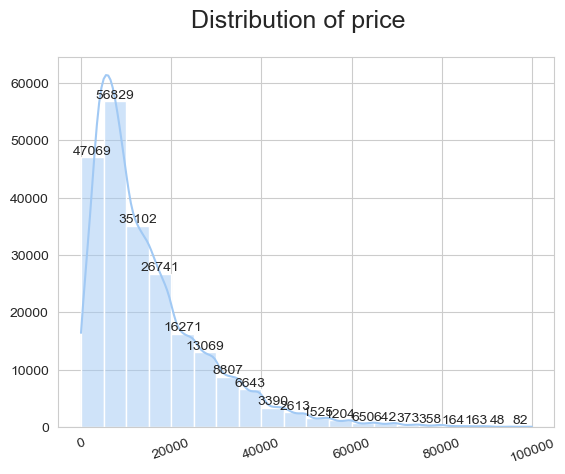

In [807]:
# Histogram/Barplots for numerical variables

ax = sns.histplot(data=vehicles_clean, x='price', bins=20, kde=True)
render_plot(ax, heading = 'Distribution of price', subtitle = '', 
            xlabel = '', ylabel = '', plotname = '2. Distribution by price.png')            


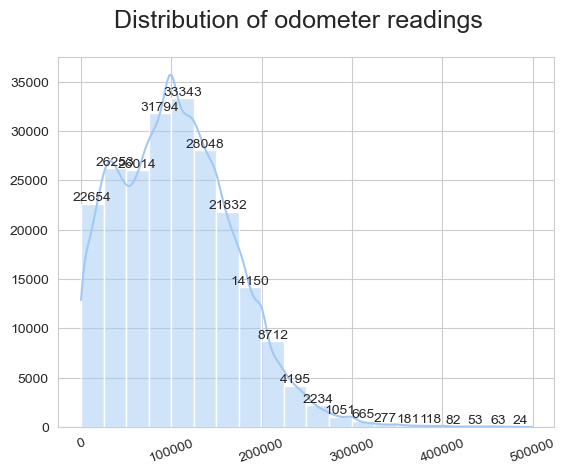

In [ ]:
ax = sns.histplot(data=vehicles_clean, x='odometer', bins=20, kde=True)
render_plot(ax, heading = 'Distribution of odometer readings', subtitle = '', 
            xlabel = '', ylabel = '', plotname = '2-Distribution by odometer readings.png')

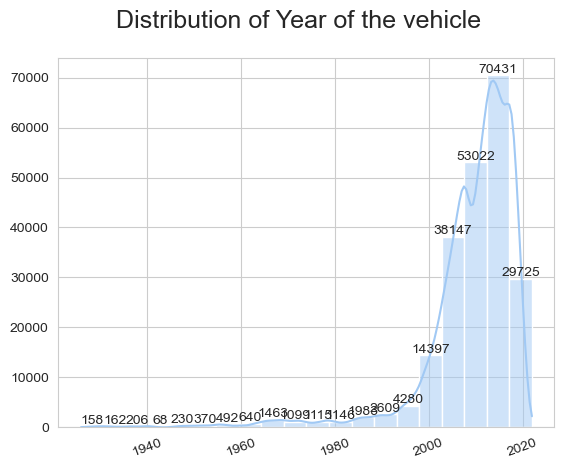

In [ ]:
ax = sns.histplot(data=vehicles_clean, x='year', bins=20, kde=True)
render_plot(ax, heading = 'Distribution of Year of the vehicle', subtitle = '', 
            xlabel = '', ylabel = '', plotname = '3-Distribution by year readings.png')

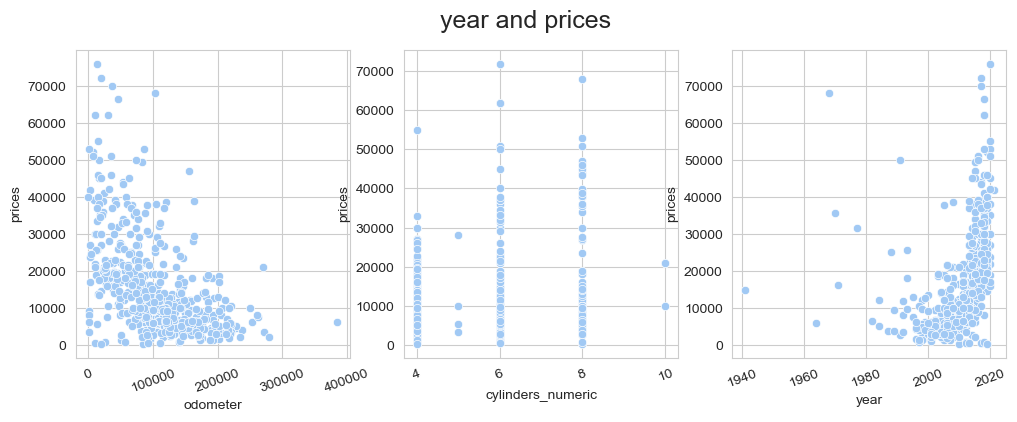

In [ ]:
np.random.seed(42)
df_numeric_sample = vehicles_clean.sample(500)

# Numerical variables
numerical_columns = ['odometer', 'cylinders_numeric', 'year']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(numerical_columns):
    ax = sns.scatterplot(x=df_numeric_sample[column], y=df_numeric_sample['price'], ax=axes[i])
    render_plot(ax, heading = f'{column} and prices', subtitle = '', 
                xlabel = column, ylabel = 'prices', plotname = f'3-{column}_vs_prices.png')    
    
    # axes[i].set_title(f'{column} and prices')
    # axes[i].set_xlabel(column)
    # axes[i].set_ylabel('prices')

# plt.tight_layout()
# plt.show()

* It appears that as age and odometer of the car increases the price goes down
* Cars with 6-8 cylinders appear to get more price
* As expected newer model vehicles command a higher value. There are exceptions with older year vehicles that require further investigation.

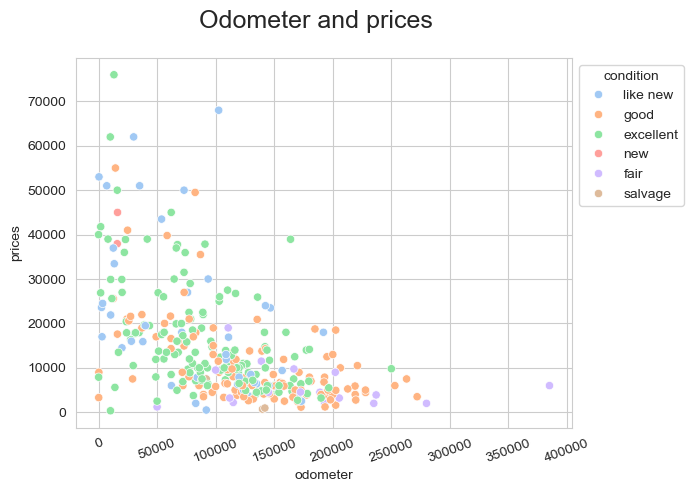

In [ ]:

ax = sns.scatterplot(x=df_numeric_sample['odometer'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

render_plot(ax, heading = 'Odometer and prices', subtitle = '',
            xlabel = 'odometer', ylabel = 'prices', plotname = '4-Odometer_vs_prices.png')

--- 
* Odometer and prices show an inverse relationship: vehicles with in excellent condition appear to be valued more than other conditions

cylinders_numeric
4.0     11767.145161
5.0     11610.250000
6.0     15009.228070
8.0     17555.886076
10.0    17298.000000
Name: price, dtype: float64


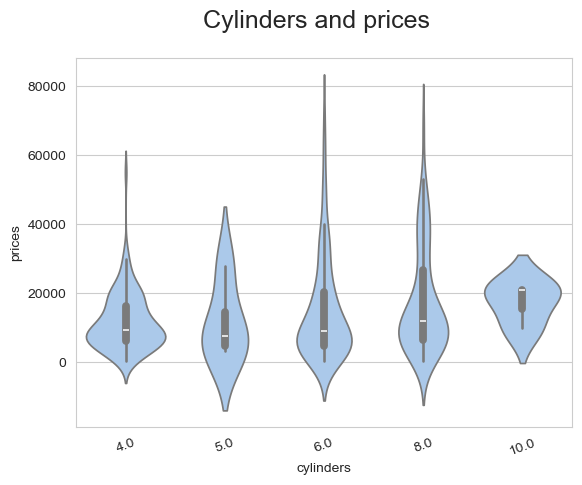

In [ ]:
#ax = sns.scatterplot(x=df_numeric_sample['cylinders_numeric'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

print(df_numeric_sample.groupby('cylinders_numeric')['price'].mean())

ax = sns.violinplot(x=df_numeric_sample['cylinders_numeric'], y=df_numeric_sample['price'])
ax.set_title('Cylinders and prices')

render_plot(ax, heading = 'Cylinders and prices', subtitle = '',
            xlabel = 'cylinders', ylabel = 'prices', plotname = '5-Cylinders_vs_prices.png')

--- 
* number of cylinders and prices show an positive relationship: vehicles with more
         number of cylinders are valued more, assuming the condition is like new

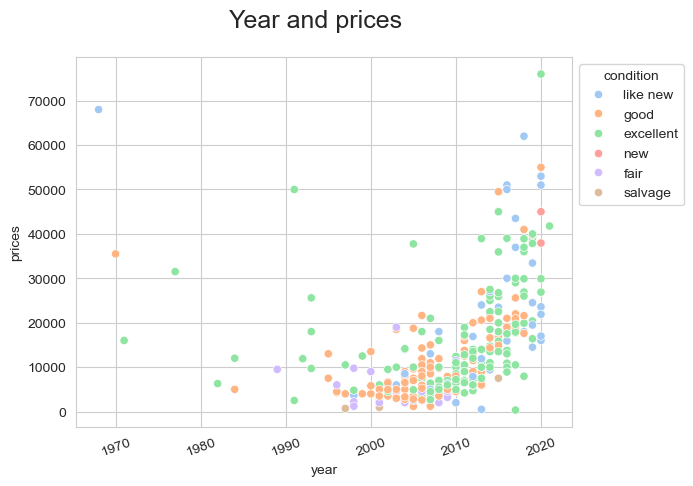

In [ ]:
ax = sns.scatterplot(x=df_numeric_sample['year'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

render_plot(ax, heading = 'Year and prices', subtitle = '',
            xlabel = 'year', ylabel = 'prices', plotname = '6-Year_vs_prices.png')



--- 
* Years and prices: newer vehicles appear to command higher prices : There are situations such as a like new car that is year 1970 at the top of the chart. This may be an error in the data set or the car never have been driven

In [814]:
#sns.pairplot(df_numeric_sample , hue='condition' )

##### Interpretation

* Customers value vehicles with higher number of cylinders (4,6,8)
* Customers do not value vehicles that are older, and have lots of mileage on the odometers

#### EDA for Categorical Variables

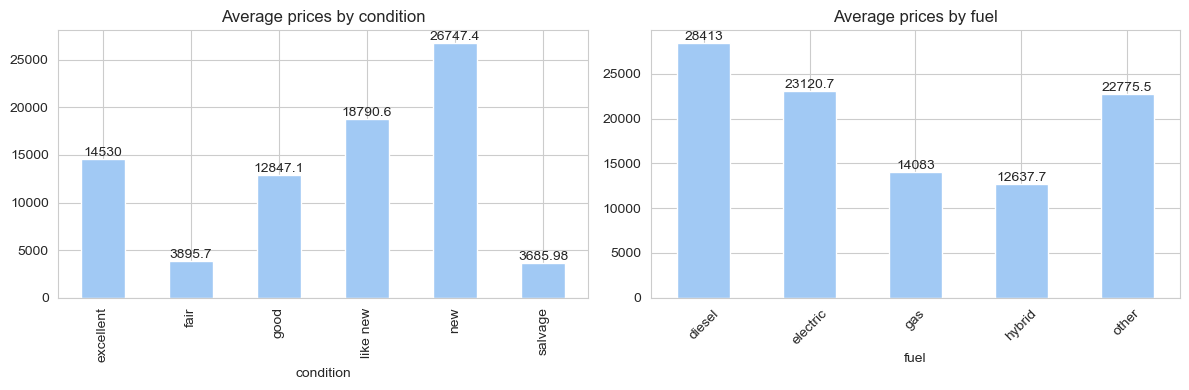

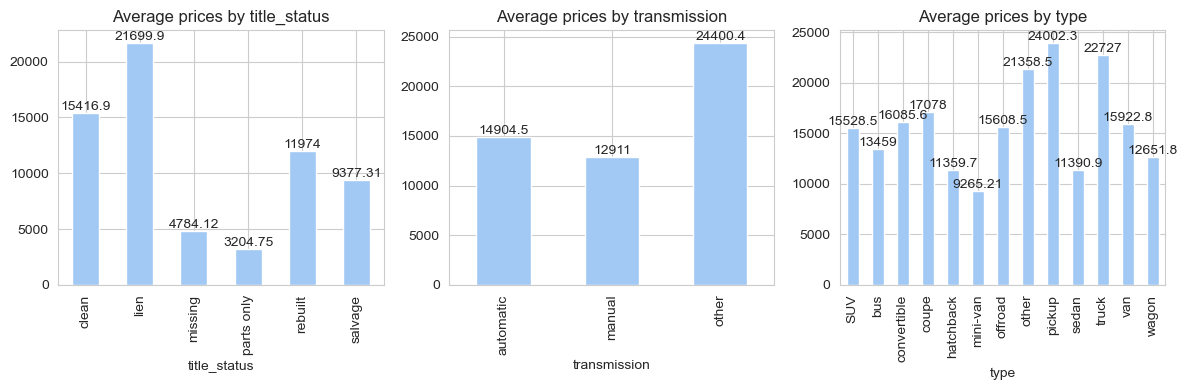

In [838]:

# Let's explore the price with categorical variables

categorical_columns = ['condition',  'fuel']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].bar_label(axes[i].containers[0])

fig.savefig('plots/7-Average_prices_by_condition_fuel.png', bbox_inches='tight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

categorical_columns = ['title_status', 'transmission', 'type']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].bar_label(axes[i].containers[0])

fig.savefig('plots/8-Average_prices_by_title_status_transmission_type.png', bbox_inches='tight')
plt.tight_layout()
plt.show()



---
* Vehicles with condition `(New/Like New)` tend to be priced higher. On the other hands cars with `salvaged` condition tend to be priced the lowest
* `Pickups` tend to attract higher prices, mini-vans on the other hand appear to sell for less
* `Diesel` vehicles tend to attract higher prices
* Vehicles with more `cyclinders` are more expensive


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Pre-processing

1. Split the data into train/test sets, before imputing any of the missing values
2. Standardize and scale the data using StandardScaler()
3. Impute the categorical values using the Imputer()


In [816]:
# Split the data into train test

X = vehicles_clean.drop(columns = 'price')
y = vehicles_clean['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((177394, 11), (44349, 11))

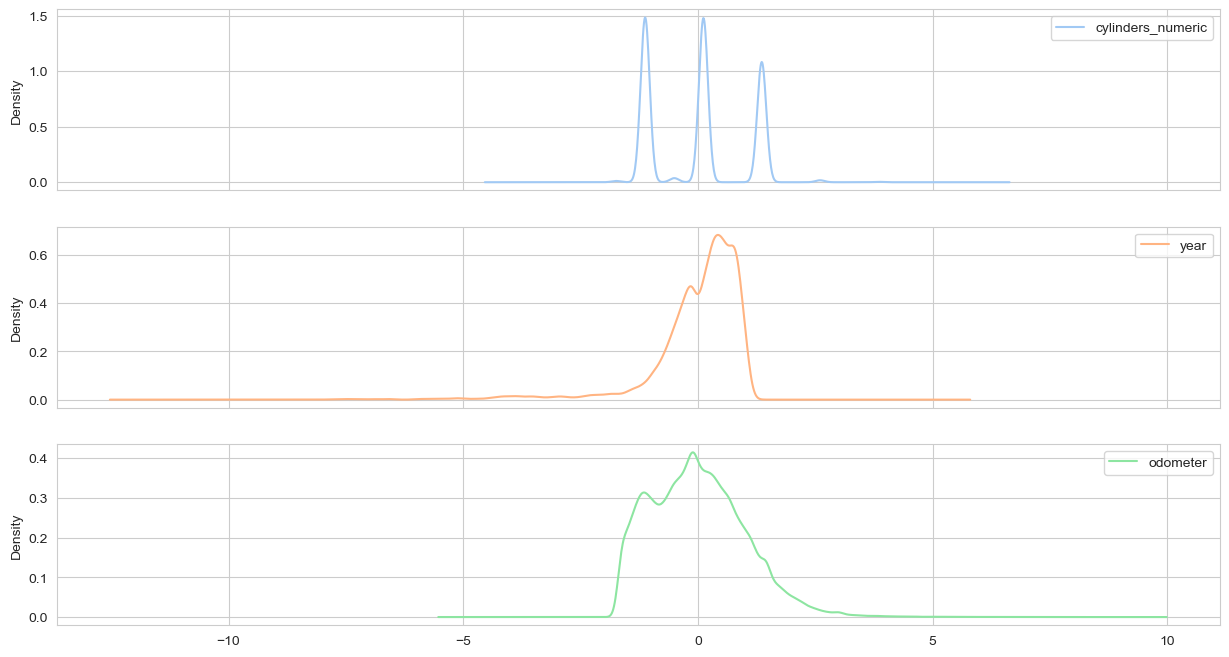

In [817]:
# initiate the Standard Scaler. this is for exploratory purposes. we will use a eventually pipeline to scale the data
# plot the kernet densities of the scaled numerical features. Pipeline will also help in imputing null values
num_features = ['cylinders_numeric', 'year', 'odometer']   

scale = StandardScaler()

X_train_transformed = pd.DataFrame(scale.fit_transform(X_train[num_features]), \
    columns = scale.get_feature_names_out())

X_train_transformed.plot(kind = 'kde', subplots = True,figsize = (15,8));


# Data set combination

* Step 1: Numerical Only
* Step 2: Numerical + Simple Categorical (OHE)
* Step 3: Step 2 + Non Trivial - Orinal Encoding

### Modeling

* We will build models for both numerical, and numerical+categorical variables. The numerical model will have polynomial, and categorical will have OHE and ordinal encoders.
* We will also change the degree of the polynomial features to determine the best degree for the model
* In total we will explore 7 models, and determine which is the best model. The evaluation of these models is summarize in a table in the Evaluation secion

In [818]:



# Create an emptry data frame to store ther results of various models evaluated
#
models_evaluated = pd.DataFrame()

# helper functions to fit and retrieve the evaluation metrics from a given model
#
def eval_model_linear (pipeline, regression_type, feature_type, poly_degree=2, model_index=''):
    
    start_time = time.time()
    
    pipeline.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    train_rmse = root_mean_squared_error(pipeline.predict(X_train), y_train)
    test_rmse = root_mean_squared_error(pipeline.predict(X_test), y_test)
    feature_names = pipeline[:-1].get_feature_names_out()
    number_of_features = len(feature_names)
    r2_test = pipeline.score(X_test, y_test)
    
    return ({'model index: ': model_index, \
            'model': regression_type, \
            'feature_type': feature_type, \
            'number of features': number_of_features, \
            'degree': poly_degree, \
            'training rmse': train_rmse, \
            'testing rmse': test_rmse, \
            'r2 test data': r2_test, 
            'best_alpha': 'n/a',
            'time to fit model (seconds):': elapsed_time})    
    

def eval_model_lasso_ridge (grid, regression_type, feature_type, poly_degree=1, model_index=''):
        
    start_time = time.time()

    grid.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    train_rmse = root_mean_squared_error(grid.predict(X_train), y_train)
    test_rmse = root_mean_squared_error(grid.predict(X_test), y_test)
    
    print("Best param: ", grid.best_params_)
    
    number_of_features = len(grid.best_estimator_.named_steps[regression_type].coef_)
    r2_test = grid.score(X_test, y_test)
    best_alpha = {list(grid.best_params_.values())[0]}
    
    return ({'model index: ': model_index, \
            'model': regression_type, \
            'feature_type': feature_type, \
            'number of features': number_of_features, \
            'degree': poly_degree, \
            'training rmse': train_rmse, \
            'testing rmse': test_rmse, \
            'r2 test data': r2_test, 
            'best_alpha': best_alpha, 
            'time to fit model (seconds):': elapsed_time})   

##### Step 1. Numerical

In [819]:
# Define the features of interest, these static values will be used in subsequent model evaluations
num_features = ['cylinders_numeric', 'year', 'odometer']       



In [820]:
# Step 1.1 Linear Regression model with numerical features only

model_index='1.11'
poly_degree = 1

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('linreg', LinearRegression())])

In [821]:
# Step 1.12 Linear Regression model with numerical features only

model_index='1.12'
poly_degree = 2

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('linreg', LinearRegression())])

In [822]:
# Step 1.13 Linear Regression model with degree 3

model_index = '1.13'
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('linreg', LinearRegression())])

In [823]:
# Step 1.2 Ridge Regression model with numerical features only

model_index = '1.2'
param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge(fit_intercept=True))])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_lasso_ridge(grid, 'ridge', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline


Best param:  {'ridge__alpha': 0.1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('ridge', Ridge())])

In [824]:
# Step 1.3 Lasso Regression model with numerical features only

model_index = 1.3
param_grid = {'lasso__alpha': [0.1, 1, 10, 100, 1000]}
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso(fit_intercept=True))])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict = eval_model_lasso_ridge(grid, 'lasso', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline


Best param:  {'lasso__alpha': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer'])])),
                ('lasso', Lasso())])

In [825]:
#models_evaluated.set_index('model index: ', inplace=True)
models_evaluated

,model index:,model,feature_type,number of features,degree,training rmse,testing rmse,r2 test data,best_alpha,time to fit model (seconds):
0,1.11,linear,All Numeric,3,1,10663.441428,10686.773965,0.345645,n/a,0.046025
1,1.12,linear,All Numeric,9,2,9626.263470,9662.716134,0.465043,n/a,0.084561
2,1.13,linear,All Numeric,19,3,9330.447622,9364.728926,0.497530,n/a,0.129090
3,1.2,ridge,All Numeric,19,3,9330.447622,9364.728893,0.497530,{0.1},2.013626
4,1.3,lasso,All Numeric,19,3,9330.449083,9364.741888,0.497528,{1},75.622624


`degree 2` model appears to provide a much better result than a degree 1 model

##### Step 2. Numerical and Categorical

In [826]:
cat_features = ['condition', 'title_status', 'manufacturer', 'type', 'fuel']


In [ ]:
# Step 2.1 Linear Regression with numerical and categorical columns

model_index = '2.1'
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('LinearRegression', LinearRegression())])

dict= eval_model_linear(pipeline, 'Linear', 'Numerical and Categorical', poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline

selected_model = pipeline

In [828]:
# Step 2.2 Ridge Regression model with numerical and categorical features

model_index = '2.2'
poly_degree = 3

param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_lasso_ridge(grid, 'ridge', 'Numerical and Categorical', poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline

Best param:  {'ridge__alpha': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition', 'title_status',
                                                   'manufacturer', 'type',
                                                   'fuel'])])),
                ('ridge', Ridge())])

In [829]:
# Step 2.3 Lasso Regression model with numerical and categorical features

model_index = '2.3'
poly_degree = 3
param_grid = {'lasso__alpha': [0.1, 1, 10, 100, 1000]}
cat_features = ['condition', 'title_status', 'type', 'fuel', 'manufacturer']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso(max_iter=10000))])

# Change the default parameters for GridSearchCV for Lasso to avoid convergence warnings - change cross validation to 2, 
# and n_jobs to -1 (to use all processors)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=2, n_jobs=-1)

dict = eval_model_lasso_ridge(grid, 'lasso', 'Numerical and Categorical',poly_degree, model_index = model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline


Best param:  {'lasso__alpha': 0.1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition', 'title_status',
                                                   'type', 'fuel',
                                                   'manufacturer'])])),
                ('lasso', Lasso(max_iter=10000))])

In [830]:
# Try Ordinal value encoding and evaluate if that improves the model
# 
cat_features_nominal = ['manufacturer', 'type', 'fuel']
cat_features_ordinal = ['condition', 'title_status']

ordinal_data_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],
    ['parts only', 'missing', 'salvage', 'rebuilt', 'lien', 'clean'],
]


In [831]:
# Step 2.4 Linear Regression with numerical and categorical columns with Ordinal Encoding

model_index = '2.4'
poly_degree = 3
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))
])

categorical_transformer_ordinal = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ordinal', OrdinalEncoder(categories=ordinal_data_categories))])

categorical_transformer_nominal = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical_ordinal', categorical_transformer_ordinal, cat_features_ordinal), 
                  ('categorical_nominal', categorical_transformer_nominal, cat_features_nominal)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linear', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'Numerical and Categorical incl Ordinal', model_index = model_index, poly_degree=poly_degree)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['cylinders_numeric', 'year',
                                                   'odometer']),
                                                 ('categorical_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal'...
                                                                                               'excellent',
                                                                                               'like '
                                                                                               'new',
                                                                                               'new'],
                                                                                              ['parts '
                                                                                               'only',
                                                                                               'missing',
                                                                                               'salvage',
                                                                                               'rebuilt',
                                                                                               'lien',
                                                                                               'clean']]))]),
                                                  ['condition',
                                                   'title_status']),
                                                 ('categorical_nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'type',
                                                   'fuel'])])),
                ('linear', LinearRegression())])

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

This analysis models LinearRegression, Ridge and Lasso regresion models for the vehicles data set
* 3 model options for numerical columns only
* 3 model options for  numerical and categorical columns
* 1 model option that includes numerical, and categorical both nominal and ordinal values

For each run of the model we captured the training rmse, test rmse, r2 score, alpha (if applicable) and time taken to fit the model

In [836]:
models_evaluated.set_index('model index: ', inplace=True)
models_evaluated

,model,feature_type,number of features,degree,training rmse,testing rmse,r2 test data,best_alpha,time to fit model (seconds):
model index:,,,,,,,,,
1.11,linear,All Numeric,3,1,10663.441428,10686.773965,0.345645,n/a,0.046025
1.12,linear,All Numeric,9,2,9626.263470,9662.716134,0.465043,n/a,0.084561
1.13,linear,All Numeric,19,3,9330.447622,9364.728926,0.497530,n/a,0.129090
1.2,ridge,All Numeric,19,3,9330.447622,9364.728893,0.497530,{0.1},2.013626
1.3,lasso,All Numeric,19,3,9330.449083,9364.741888,0.497528,{1},75.622624
2.1,Linear,Numerical and Categorical,91,3,8111.820167,8145.970206,0.619806,n/a,1.251494
2.2,ridge,Numerical and Categorical,91,3,8111.881336,8145.243408,0.619873,{1},10.625638
2.3,lasso,Numerical and Categorical,91,3,8111.870144,8145.716592,0.619829,{0.1},56.116605
2.4,linear,Numerical and Categorical incl Ordinal,81,3,8126.404362,8160.645615,0.618434,n/a,0.778935


We observed that the regression models on numerical columns had  low `r2 scores (~46%)`. These were improved with the inclusion of categorical columns with OneHotEncoding, the scores went up to `59%`. Both Ridge (alpha = 0.1) Lasso (alpha = 10) as provided by GridSearchCV (default CV=5) yield very similar results to LinearRegression models. 

We also analyzed with ordinal encoding for title_status and condition variables. However did not have an impact on the r2 score (remained `59%`)

Note: on Lasso for numerical and categorical columns. The model fit was taking a long time and providing convergence warnings, so changed the default parameters for GridSearchCV: change cross validation to 2, # and n_jobs to -1 (to use all processors)

`Conclusion`: Considering there is no improvement using Lasso or Ridge regression and time cost of these regularization models are high, I would recommend using the `LinearRegression model with both numerical and categorical variables`. This will be model index 2.1 in the above table

#### Understand the features that have the most impact on the price of the vehicle

In [ ]:
# Get the feature names from the preprocessor
feature_names = selected_model.named_steps['preprocessor'].get_feature_names_out()

# Get the coefficients from the final estimator
coefficients = selected_model.named_steps['LinearRegression'].coef_

# Create a DataFrame to display the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print("Top 5 features that have the most impact on increasing the price of the car")
print(coef_df.sort_values(by='Coefficient', ascending=False).head(20))

print("Top 5 features that have the most impact on lowering the price of the car")
print(coef_df.sort_values(by='Coefficient', ascending=True).head(20))

Top 5 features that have the most impact on increasing the price of the car
                                   Feature   Coefficient
42       categorical__manufacturer_ferrari  46358.079382
69         categorical__manufacturer_tesla  19872.511463
33  categorical__manufacturer_aston-martin  17214.310435
64       categorical__manufacturer_porsche  12665.923858
86                categorical__fuel_diesel  10951.901089
1                          numerical__year   9320.512191
66         categorical__manufacturer_rover   5467.101258
26          categorical__title_status_lien   4757.751403
6                        numerical__year^2   4337.250209
81                categorical__type_pickup   3902.236323
53    categorical__manufacturer_land rover   3603.552704
25         categorical__title_status_clean   3301.222495
79               categorical__type_offroad   3063.798483
83                 categorical__type_truck   2729.844265
75           categorical__type_convertible   2450.978703
22         c

##### Ways to improve the model

a. The original data set had a lot of `missing data, ranging from 20 to 40%` for these columns
* condition       40.79
* cylinders       41.62
* drive           30.59
* type            21.75

These features were imputed using mode method. Perhaps KNeighborsClassifier may be used to find values for these categorical variables

b. Instead of computing missing values, when all missing values are dropped, the data shrinks to 15% of it's original size. This translates to 60K records. Running the above models in this data data set may have an impact on the r2 scores. It requires further investigation on spread of data in this significanly reduced data set and whether it provides a good representation of the 
overall data


### Sample predictions

This is just for me to get an understanding of how to use such a prediction capability in the real world


In [ ]:
# our pipeline imputed new values for missing values. For the purposes of testing prediction on the columns
# we will drop the rows with missing values

df = vehicles_clean.dropna()

df.sample(5)

df2 = df.sample()
print("predicted price: ", selected_model.predict(df2)[0])
print("error in prediction:", (df2.price - selected_model.predict(df2)).values[0])

print("\n",df2)

predicted price:  9309.483097418593
error in prediction: 2690.5169025814066

         price    year manufacturer condition fuel  odometer title_status  \
321285  12000  2007.0         mini  like new  gas   55000.0        clean   

       transmission drive   type paint_color  cylinders_numeric  
321285       manual   fwd  coupe      yellow                4.0  


In [ ]:
# predict a few fictitious samples to view the results of the model
# 

to_predict = pd.DataFrame(data = {'manufacturer': ['toyota'], 'condition': ['good'], 'cylinders_numeric': [6], 'fuel': ['gas'], 'odometer': [100000], \
    'title_status': ['clean'], 'transmission': ['manual'], 'type': ['sedan'], 'year': [2005]}) 

print("predicted price for 2005 TOYOTA, 6 cyl, clean title, 100k miles: ", selected_model.predict(to_predict)[0])

to_predict = pd.DataFrame(data = {'manufacturer': ['audi'], 'condition': ['good'], 'cylinders_numeric': [6], 'fuel': ['gas'], 'odometer': [100000], \
    'title_status': ['clean'], 'transmission': ['manual'], 'type': ['sedan'], 'year': [2005]}) 
print("predicted price for 2005 AUDI, 6 cyl, clean title, 100k miles: ", selected_model.predict(to_predict)[0])

to_predict = pd.DataFrame(data = {'manufacturer': ['ford'], 'condition': ['good'], 'cylinders_numeric': [6], 'fuel': ['gas'], 'odometer': [100000], \
    'title_status': ['clean'], 'transmission': ['manual'], 'type': ['sedan'], 'year': [2005]}) 
print("predicted price for 2005 FORD, 6 cyl, clean title, 100k miles: ", selected_model.predict(to_predict)[0])


predicted price for 2005 TOYOTA, 6 cyl, clean title, 100k miles:  6389.372043926401
predicted price for 2005 AUDI, 6 cyl, clean title, 100k miles:  7869.892326278918
predicted price for 2005 FORD, 6 cyl, clean title, 100k miles:  5453.419721807885
